# kNN ON Fashion-MINIST

In [2]:
import utils.mnist_reader as mnist_reader
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

seed = 0
np.random.seed(seed) 

Load Fashin-MNIST dataset

In [3]:
X, y = mnist_reader.load_mnist('data/fashion', kind='train')
X_te, y_te = mnist_reader.load_mnist('data/fashion', kind='t10k')

## Tune Hyperparameters

To ensure the kNN classifier to have a good performance in predicting new datapoints on the Fashion-MNIST. The first step is to focus on tuning the hyperparameters of the kNN classifier, ensure the model could have a optimal accuracies in predicting new datapoints. In here, we will specifically focus on tuning the number of neighbors and the distance metric used for calculating distances between datapoints. To avoid potential data leakage or overfitting when tuning the hyperparameter. We will split a 25% data from the training set as validation set for tuning purposes, and holdout the testing set for final evaluation.

In [4]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=seed, shuffle=True)

In [5]:
print(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape)

(45000, 784) (15000, 784) (45000,) (15000,)


Calculate kNN accuracies with different k-vals and metrics. We will use the first 15000 datapoints

In [6]:
k_vals = [3, 5, 7, 9, 11]
metrics = ['minkowski','euclidean','manhattan']
n = 15000

trials = []
for k in k_vals:
    print(k)
    for m in metrics:
        print(m)
        clf = KNeighborsClassifier(n_neighbors=k, metric=m)
        clf.fit(X_tr[:n], y_tr[:n])

        # compute training error and testing error
        y_tr_pred = clf.predict(X_tr[:n])
        tr_err = 1 - accuracy_score(y_tr[:n], y_tr_pred)

        y_val_pred = clf.predict(X_val[:n])
        val_err = 1 - accuracy_score(y_val[:n], y_val_pred)

        trials.append((k, m, tr_err, val_err))


print(trials)


3
minkowski
euclidean
manhattan
5
minkowski
euclidean
manhattan
7
minkowski
euclidean
manhattan
9
minkowski
euclidean
manhattan
11
minkowski
euclidean
manhattan
[(3, 'minkowski', 0.09406666666666663, 0.17013333333333336), (3, 'euclidean', 0.09406666666666663, 0.17013333333333336), (3, 'manhattan', 0.09253333333333336, 0.16273333333333329), (5, 'minkowski', 0.11260000000000003, 0.16833333333333333), (5, 'euclidean', 0.11260000000000003, 0.16833333333333333), (5, 'manhattan', 0.1091333333333333, 0.16133333333333333), (7, 'minkowski', 0.12613333333333332, 0.17213333333333336), (7, 'euclidean', 0.12613333333333332, 0.17213333333333336), (7, 'manhattan', 0.12373333333333336, 0.16413333333333335), (9, 'minkowski', 0.13673333333333337, 0.1757333333333333), (9, 'euclidean', 0.13673333333333337, 0.1757333333333333), (9, 'manhattan', 0.12939999999999996, 0.16693333333333338), (11, 'minkowski', 0.14146666666666663, 0.1777333333333333), (11, 'euclidean', 0.14146666666666663, 0.1777333333333333), (

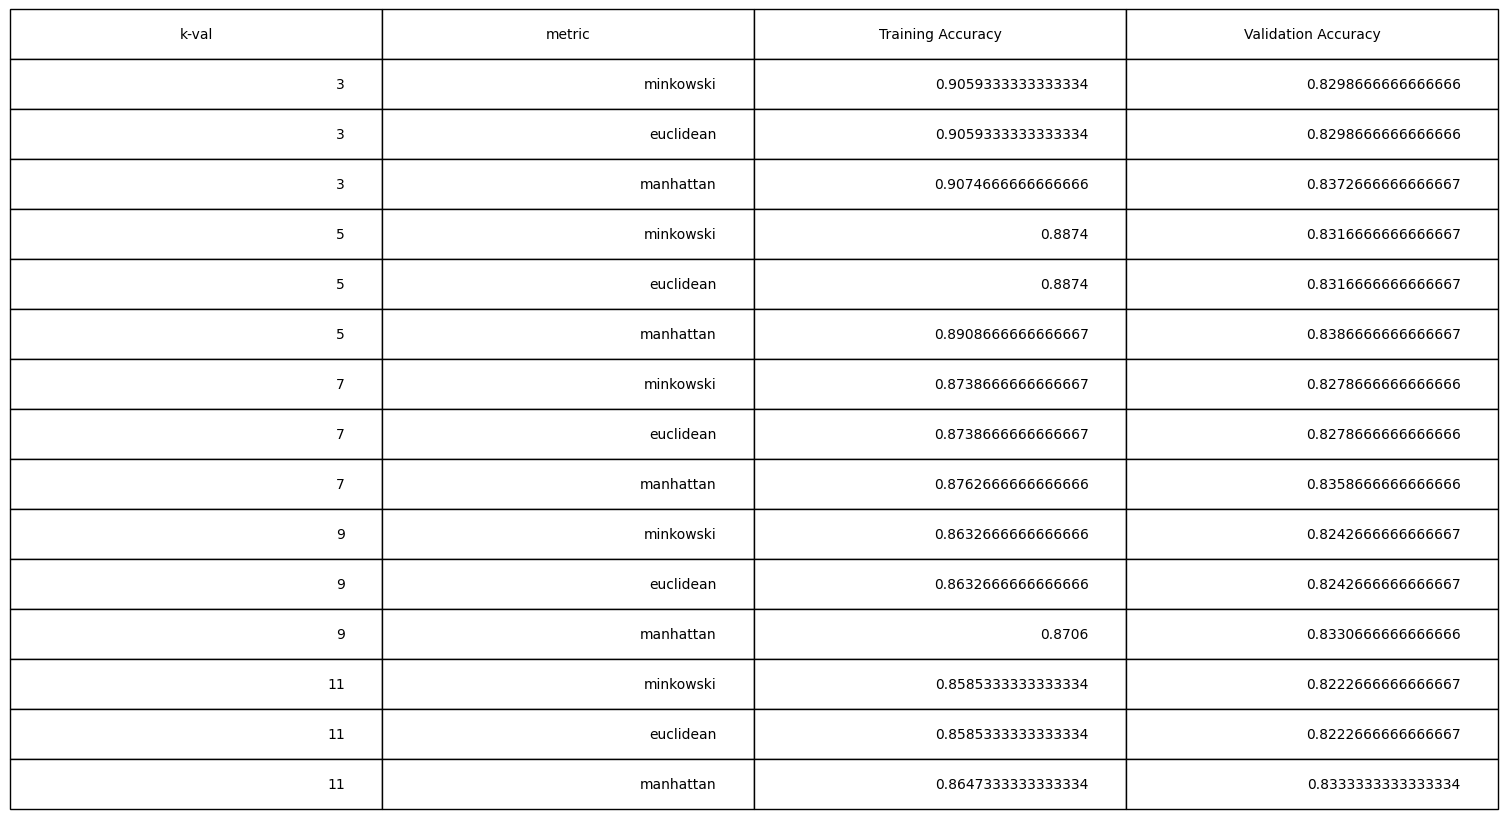

In [12]:
columns = ['k-val', 'metric', 'Training Accuracy', 'Validation Accuracy']

data = []
for trial in trials:
    row = []
    row.append(trial[0])
    for col in columns[1:-2]:
        row.append(str(trial[1]))

    row.append(1 - trial[2])
    row.append(1 - trial[3])

    data.append(row)

figure, axes = plt.subplots()


axes.axis('off')
table = axes.table(cellText=data, colLabels=columns, loc='center')
table.set_fontsize(10)
table.scale(3, 3)


Based on the table for the first 15000 training datapoints. The classifier has highest validation accuracies when k=5 with distance metric manhattan. We will continue using these hyperparameter to evaluate our model performance on the test dataset

## Confusion Matrix and Ranking-based Metrics

Now, we will plot the confusion matrix to visualize the performance of the kNN classifier on Fashin MNIST dataset. The confusion matrix could help to visualize what labels are being correctly or incorrectly predicted.

We evaluate it on the validation dataset.

The kNN Classifier Has Accuracy (train): 0.8974
The kNN Classifier Has Accuracy (testing): 0.849


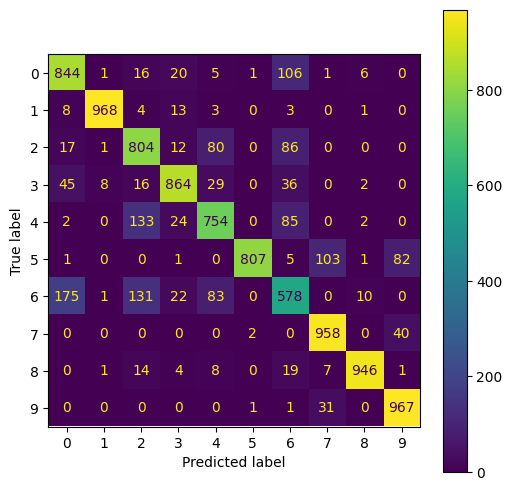

In [6]:
figure, axes = plt.subplots(figsize=(6, 6))

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_tr, y_tr)

y_tr_pred = clf.predict(X_tr)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_te)

# plot confusion matrix
axes.title("kNN Confusion Matrix on Testing Dataset")
cm = confusion_matrix(y_te, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot(ax=axes)

acc_tr = accuracy_score(y_tr, y_tr_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_te = accuracy_score(y_te, y_test_pred)

print(f"The kNN Classifier Has Accuracy (train): {acc_tr}")
print(f"The kNN Classifier Has Accuracy (testing): {acc_te}")

<Axes: >

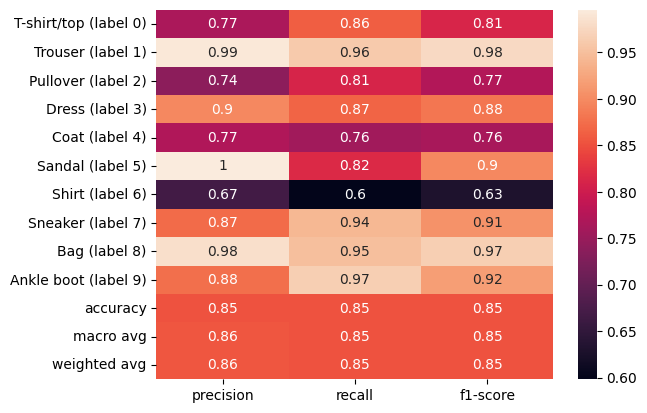

In [10]:


label2desc = {0: 'T-shirt/top (label 0)', 
              1: 'Trouser (label 1)', 
              2: 'Pullover (label 2)', 
              3: 'Dress (label 3)', 
              4: 'Coat (label 4)', 
              5: 'Sandal (label 5)', 
              6: 'Shirt (label 6)', 
              7: 'Sneaker (label 7)',
              8: 'Bag (label 8)',
              9: 'Ankle boot (label 9)'}



report = classification_report(y_val, y_val_pred, target_names = label2desc.values(), output_dict=True)

sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)


Referring to the confusion matrix, row 6 column 0, a off-diagonal cell that can be considered as error, has the highest counts. This means that 252 datapoints that were actually labeled as Shirt (label 6) but were predicted as T-shirt/top (label 0), suggesting that the classifier often confuses Shirts with T-shirts/tops.

Furthemore, referring to the heatmap.Shirt (label 6) has the lowest precision and recall. Since precision measures the likelihood of correctly classifying the positive prediction, recall measures the proportion of true positive that are correctly classified. This means that if the classifier predicts the datapoint as Shirt, it is correct only 67% of time. Additionally, among all the datapoint that are actually Shirts, the classifier could only identified 60% of them as Shirt. Ultimately, looking at the f1-score, which combines and balances both precision and recall scores, illustrates that the classfier has the lowest accuracy in predicting Shirts, followed by Coat (label 4) with an F1-score of 0.76 and Pullover (label 2) with an F1-score of 0.77.

<b> Hypothesis on why the classifier has lowest accuracy in predictying shirts: </b> One hypothesis is that the features, which are the pixel values of the images, for Shirts are similar to certain other clothing categories in the dataset. Since kNN classifier classify new datapoint by estimating the majority labels of the k nearest training data, similar visual patterns would indicate that the feature vectors of these labels are close to one another. This will increase the likelihood of the kNN classifier to assign the new feature vectors to wrong labels. For instance, Shirts and T-shirts/tops can exhibit the same visual patterns, which makes the classifier often confuses Shirts with T-shirts as previously discussed on the confusion matrix. Similarly, other labels such as Dress (label 3), Coat (label 4), and Pullover (label 2) also exhibit lower accuracy (<0.9 F1-score) as they also have similar visual patterns

## Leaning Curves
TODO: description

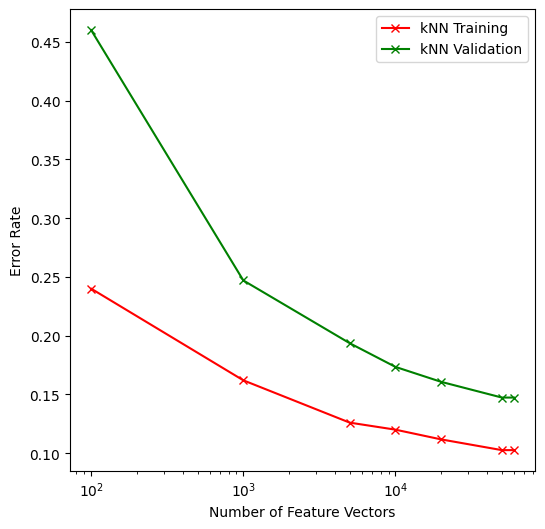

In [11]:
figure, axes = plt.subplots(1, figsize=(6, 6))

n_tr = [100, 1000, 5000, 10000, 20000, 50000, 45000]

tr_errors = []
val_errors = []

for n in n_tr:
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_tr[:n], y_tr[:n])

    # compute training error and testing error
    y_tr_pred = clf.predict(X_tr)
    tr_errors.append(1 - accuracy_score(y_tr, y_tr_pred))

    y_val_pred = clf.predict(X_val)
    val_errors.append(1 - accuracy_score(y_val, y_val_pred))


axes.set_xlabel("Number of Feature Vectors")
axes.set_ylabel("Error Rate")
axes.semilogx(n_tr, tr_errors, marker='x', color='red', label="kNN Training")
axes.semilogx(n_tr, val_errors, marker='x', color='green', label="kNN Validation")
axes.legend()

## Interpretability
Investigate which features the model is relying on